In [2]:
# On Colab or locally (if not installed)
!pip install torch

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
from google.colab import files
import os

# upload your files interactively
uploaded = files.upload()

# then the files will be in the current working directory
TRAIN_FILE = "Shakespeare_clean_train.txt"
VALIDATION_FILE = "Shakespeare_clean_valid.txt"
TEST_FILE = "Shakespeare_clean_test.txt"

# Define model save path inside your Drive
SAVE_FOLDER = "/content/drive/MyDrive/colab_models"
os.makedirs(SAVE_FOLDER, exist_ok=True)
SAVE_PATH = os.path.join(SAVE_FOLDER, "gpt_model_new.pt")

Saving Shakespeare_clean_test.txt to Shakespeare_clean_test.txt
Saving Shakespeare_clean_train.txt to Shakespeare_clean_train.txt
Saving Shakespeare_clean_valid.txt to Shakespeare_clean_valid.txt


In [5]:
"""

Mini GPT (Colab-Version)

"""
from __future__ import annotations
import math, random
from dataclasses import dataclass
from collections import Counter, defaultdict
from typing import List, Tuple, Dict, Iterable, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Gpu device selection
def get_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device("cuda")
    if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

DEVICE = get_device()

# Minimal from scratch BPE tokenizer
class SimpleBPE:
    def __init__(self, num_merges: int = 2000):
        self.num_merges = int(num_merges)
        self.vocab: Dict[Tuple[int, ...], int] = {}
        self.id2tok: Dict[int, Tuple[int, ...]] = {}
        self.merges: Dict[Tuple[int, int], int] = {}
        self.vocab_size: int = 256
        self.trained = False

    @staticmethod
    def _to_bytes(text: str) -> List[int]:
        return list(text.encode("utf-8"))

    @staticmethod
    def _from_bytes(ids: List[int]) -> str:
        return bytes(ids).decode("utf-8", errors="ignore")

    def train(self, texts: Iterable[str]):
        self.vocab = { (i,): i for i in range(256) }
        self.id2tok = { i: (i,) for i in range(256) }
        self.vocab_size = 256
        corpus: List[List[int]] = [self._to_bytes(t) for t in texts]

        def get_pair_stats(seqs):
            stats = Counter()
            for seq in seqs:
                for a, b in zip(seq, seq[1:]):
                    stats[(a, b)] += 1
            return stats

        def merge_pair(seqs, pair, new_id):
            a, b = pair
            updated = []
            for seq in seqs:
                i, merged = 0, []
                while i < len(seq):
                    if i < len(seq)-1 and seq[i] == a and seq[i+1] == b:
                        merged.append(new_id); i += 2
                    else:
                        merged.append(seq[i]); i += 1
                updated.append(merged)
            return updated

        for _ in range(self.num_merges):
            stats = get_pair_stats(corpus)
            if not stats: break
            (a, b), _ = stats.most_common(1)[0]
            new_id = self.vocab_size
            self.vocab[(a, b)] = new_id
            self.id2tok[new_id] = (a, b)
            self.merges[(a, b)] = new_id
            self.vocab_size += 1
            corpus = merge_pair(corpus, (a, b), new_id)
        self.trained = True

    def encode(self, text: str) -> List[int]:
        assert self.trained
        seq = self._to_bytes(text)
        merged = True
        while merged:
            merged, i, out = False, 0, []
            while i < len(seq):
                if i < len(seq)-1 and (seq[i], seq[i+1]) in self.merges:
                    out.append(self.merges[(seq[i], seq[i+1])]); i += 2; merged = True
                else:
                    out.append(seq[i]); i += 1
            seq = out
        return seq

    def decode(self, ids: List[int]) -> str:
        stack: List[int] = []
        def expand(tok_id):
            if tok_id in self.id2tok:
                for x in self.id2tok[tok_id]:
                    if x < 256: stack.append(x)
                    else: expand(x)
            else: stack.append(tok_id)
        for tid in ids: expand(tid)
        return self._from_bytes(stack)


# n-gram for perplexity comparision
class NGramLM:
    def __init__(self, n=3):
        self.n = n
        self.counts = defaultdict(Counter)
        self.context_counts = Counter()
        self.vocab_size = 0

    def fit(self, sequences, vocab_size):
        self.vocab_size = vocab_size
        for seq in sequences:
            padded = [0]*(self.n-1) + seq
            for i in range(self.n-1, len(padded)):
                ctx = tuple(padded[i-self.n+1:i])
                tok = padded[i]
                self.counts[ctx][tok] += 1
                self.context_counts[ctx] += 1

    def perplexity(self, sequences):
        logprob, N = 0.0, 0
        for seq in sequences:
            padded = [0]*(self.n-1) + seq
            for i in range(self.n-1, len(padded)):
                ctx = tuple(padded[i-self.n+1:i])
                tok = padded[i]
                num = self.counts[ctx][tok] + 1
                den = self.context_counts[ctx] + self.vocab_size
                p = num / den
                logprob += -math.log(p + 1e-12)
                N += 1
        return math.exp(logprob/max(N,1))

# instead of grid search
def sweep_bpe_merges(texts, candidates, ngram_n=3):
    results = []
    for merges in candidates:
        tok = SimpleBPE(num_merges=merges)
        tok.train(texts)
        cut = int(0.8*len(texts))
        train_txt, held_txt = texts[:cut], texts[cut:]
        train_ids = [tok.encode(t) for t in train_txt]
        held_ids = [tok.encode(t) for t in held_txt]
        lm = NGramLM(n=ngram_n)
        lm.fit(train_ids, tok.vocab_size)
        ppl = lm.perplexity(held_ids)
        results.append((merges, ppl, tok.vocab_size))
    results.sort(key=lambda x: x[1])
    return results[:3], results


# GPT model

# config
@dataclass
class GPTConfig:
    vocab_size: int
    n_embd: int = 192
    n_head: int = 6
    n_layer: int = 6
    block_size: int = 128
    dropout: float = 0.1

class CausalSelfAttention(nn.Module):
    def __init__(self, n_embd, n_head, dropout, block_size):
        super().__init__()
        assert n_embd % n_head == 0
        self.n_head = n_head
        self.head_dim = n_embd // n_head
        self.q_proj = nn.Linear(n_embd, n_embd)
        self.k_proj = nn.Linear(n_embd, n_embd)
        self.v_proj = nn.Linear(n_embd, n_embd)
        self.out_proj = nn.Linear(n_embd, n_embd)
        self.attn_drop = nn.Dropout(dropout)
        self.resid_drop = nn.Dropout(dropout)
        mask = torch.tril(torch.ones(block_size, block_size)).view(1,1,block_size,block_size)
        self.register_buffer("mask", mask)
    def forward(self, x):
        B,T,C = x.size()
        q = self.q_proj(x).view(B,T,self.n_head,self.head_dim).transpose(1,2)
        k = self.k_proj(x).view(B,T,self.n_head,self.head_dim).transpose(1,2)
        v = self.v_proj(x).view(B,T,self.n_head,self.head_dim).transpose(1,2)
        att = (q @ k.transpose(-2,-1)) / math.sqrt(self.head_dim)
        att = att.masked_fill(self.mask[:,:,:T,:T]==0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v
        y = y.transpose(1,2).contiguous().view(B,T,C)
        return self.resid_drop(self.out_proj(y))

class MLP(nn.Module):
    def __init__(self, n_embd, dropout):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(n_embd, 4*n_embd), nn.GELU(), nn.Linear(4*n_embd, n_embd), nn.Dropout(dropout))
    def forward(self, x): return self.fc(x)

class Block(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.ln1 = nn.LayerNorm(cfg.n_embd)
        self.attn = CausalSelfAttention(cfg.n_embd, cfg.n_head, cfg.dropout, cfg.block_size)
        self.ln2 = nn.LayerNorm(cfg.n_embd)
        self.mlp = MLP(cfg.n_embd, cfg.dropout)
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class GPT(nn.Module):
    def __init__(self, cfg: GPTConfig):
        super().__init__()
        self.cfg = cfg
        self.tok_emb = nn.Embedding(cfg.vocab_size, cfg.n_embd)
        self.pos_emb = nn.Parameter(torch.zeros(1, cfg.block_size, cfg.n_embd))
        self.drop = nn.Dropout(cfg.dropout)
        self.blocks = nn.ModuleList([Block(cfg) for _ in range(cfg.n_layer)])
        self.ln_f = nn.LayerNorm(cfg.n_embd)
        self.head = nn.Linear(cfg.n_embd, cfg.vocab_size, bias=False)

    def forward(self, idx, targets=None, label_smoothing=0.0):
        B,T = idx.size()
        pos = self.pos_emb[:,:T,:]
        x = self.drop(self.tok_emb(idx)+pos)
        for blk in self.blocks: x = blk(x)
        x = self.ln_f(x)
        logits = self.head(x)
        if targets is None: return logits, None
        if label_smoothing > 0:
            logprobs = F.log_softmax(logits, dim=-1)
            nll = F.nll_loss(logprobs.view(-1, logprobs.size(-1)), targets.view(-1), reduction='none')
            uniform = -logprobs.mean(dim=-1).view(-1)
            loss = ((1-label_smoothing)*nll + label_smoothing*uniform).mean()
        else:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens=50, temperature=1.0, top_k=None):
        self.eval()
        for _ in range(max_new_tokens):
            idx_cond = idx[:,-self.cfg.block_size:]
            logits,_ = self(idx_cond)
            logits = logits[:,-1,:]/max(temperature,1e-6)
            if top_k is not None:
                v,_ = torch.topk(logits, k=top_k)
                thresh = v[:,-1,None]
                logits = torch.where(logits<thresh, torch.full_like(logits,-float('inf')), logits)
            probs = F.softmax(logits, dim=-1)
            next_tok = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, next_tok], dim=1)
        return idx


# training helpers
def batchify(data, block_size, batch_size, device):
    i=0
    while True:
        X,Y=[],[]
        for _ in range(batch_size):
            seq = data[i % len(data)]
            if len(seq)<2: i+=1; continue
            start = random.randint(0,max(1,len(seq)-block_size-1))
            chunk = seq[start:start+block_size+1]
            x,y = chunk[:-1], chunk[1:]
            X.append(x); Y.append(y); i+=1
        x = torch.tensor(X, dtype=torch.long, device=device)
        y = torch.tensor(Y, dtype=torch.long, device=device)
        yield x,y

@torch.no_grad()
def eval_perplexity(model, val_data, batch_size=32):
    model.eval()
    nll,N=0.0,0
    for i in range(0,len(val_data),batch_size):
        batch = val_data[i:i+batch_size]
        maxT = min(max(len(s) for s in batch), model.cfg.block_size)
        x = torch.full((len(batch),maxT-1),0,dtype=torch.long,device=DEVICE)
        y = torch.full((len(batch),maxT-1),0,dtype=torch.long,device=DEVICE)
        for bi,s in enumerate(batch):
          s = s[:maxT]  # truncate if too long
          x[bi,:len(s)-1] = torch.tensor(s[:-1],device=DEVICE)
          y[bi,:len(s)-1] = torch.tensor(s[1:],device=DEVICE)
        _,loss = model(x,y)
        nll += loss.item()*(maxT-1)*len(batch)
        N += (maxT-1)*len(batch)
    return math.exp(nll/max(N,1))

# model's save/Load helpers
def save_model(model, path):
  torch.save(model.state_dict(), path)


def load_model(path, cfg):
  model = GPT(cfg)
  model.load_state_dict(torch.load(path, map_location=DEVICE))
  model.to(DEVICE)
  return model



iter 10/100 | loss 6.428 | val ppl 488.42
iter 20/100 | loss 5.737 | val ppl 262.47
iter 30/100 | loss 5.566 | val ppl 217.64
iter 40/100 | loss 5.450 | val ppl 198.45
iter 50/100 | loss 5.479 | val ppl 183.14
iter 60/100 | loss 5.223 | val ppl 159.62
iter 70/100 | loss 5.014 | val ppl 135.28
iter 80/100 | loss 4.860 | val ppl 125.89
iter 90/100 | loss 4.824 | val ppl 113.58
iter 100/100 | loss 4.889 | val ppl 103.49


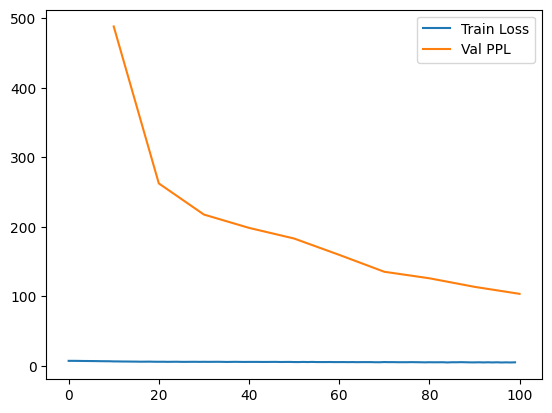

Model saved to /content/drive/MyDrive/colab_models/gpt_model.pt
Model reloaded from Drive!
Generated: I think: I Iy witht but the fra, of mt! STy. OTHELLO no to of Hith; it SDEMin Butve this of is gainnees borserstied! Wile, in the ces Beart that, and inoth  neng: T the dl. Good ofr aby to; Mat Wh


In [7]:
if __name__ == "__main__":

    with open(TRAIN_FILE, "r", encoding="utf-8") as f:
        train_texts = f.read().splitlines()
    with open(VALIDATION_FILE, "r", encoding="utf-8") as f:
        val_texts = f.read().splitlines()

    merge_candidates=[700,1800,4000]
    top3,_ = sweep_bpe_merges(train_texts, merge_candidates)
    best_merges = top3[0][0] if top3 else 500
    tokenizer=SimpleBPE(num_merges=best_merges); tokenizer.train(train_texts)

    train=[tokenizer.encode(t) for t in train_texts]
    val=[tokenizer.encode(t) for t in val_texts]

    cfg = GPTConfig(vocab_size=tokenizer.vocab_size, n_embd=128, n_head=4, n_layer=2, block_size=64)
    model = GPT(cfg).to(DEVICE)
    optimiser = torch.optim.AdamW(model.parameters())

    train_losses, val_ppls, steps = [], [], []
    bs, iters = 8, 100
    stream = batchify(train, cfg.block_size, bs, DEVICE)

    for it in range(iters):
        x,y=next(stream)
        optimiser.zero_grad(set_to_none=True)
        _,loss=model(x,y)
        loss.backward(); optimiser.step()
        train_losses.append(loss.item())
        if (it+1)%10==0:
            ppl=eval_perplexity(model,val)
            val_ppls.append(ppl); steps.append(it+1)
            print(f"iter {it+1}/{iters} | loss {loss.item():.3f} | val ppl {ppl:.2f}")

    plt.plot(range(len(train_losses)), train_losses, label="Train Loss")
    plt.plot(steps, val_ppls, label="Val PPL")
    plt.legend(); plt.show()

    save_model(model, SAVE_PATH)
    print(f"Model saved to {SAVE_PATH}")


    loaded = load_model(SAVE_PATH, cfg)
    print("Model reloaded from Drive!")

    ctx = torch.tensor([tokenizer.encode("I think")],dtype=torch.long,device=DEVICE)
    out = loaded.generate(ctx, max_new_tokens=100, temperature=0.9, top_k=50)
    print("Generated:", tokenizer.decode(out[0].tolist()))


In [10]:
# for improvements resume model training if needed

# load model from checkpoint
cfg = GPTConfig(
    vocab_size=tokenizer.vocab_size,
    n_embd=128, n_head=4, n_layer=2, block_size=64
)
model = load_model(SAVE_PATH, cfg).to(DEVICE)

# optimizer
optimiser = torch.optim.AdamW(model.parameters())

# resume training parameters
bs = 8            # batch size
extra_iters = 10000 # number of additional iterations

# stream of training batches
stream = batchify(train, cfg.block_size, bs, DEVICE)

# resume training
for it in range(extra_iters):
    x, y = next(stream)
    optimiser.zero_grad(set_to_none=True)
    _, loss = model(x, y)
    loss.backward()
    optimiser.step()

    if (it+1) % 50 == 0:
        print(f"Iteration {it+1}/{extra_iters} | Loss {loss.item():.3f}")




save_model(model, SAVE_PATH)
print(f"Model saved to {SAVE_PATH}")


loaded = load_model(SAVE_PATH, cfg)
print("Model reloaded from Drive!")

ctx = torch.tensor([tokenizer.encode("I think")],dtype=torch.long,device=DEVICE)
out = loaded.generate(ctx, max_new_tokens=100, temperature=0.9, top_k=50)
print("Generated:", tokenizer.decode(out[0].tolist()))


Iteration 50/10000 | Loss 3.203
Iteration 100/10000 | Loss 3.142
Iteration 150/10000 | Loss 3.086
Iteration 200/10000 | Loss 3.019
Iteration 250/10000 | Loss 2.980
Iteration 300/10000 | Loss 3.222
Iteration 350/10000 | Loss 3.047
Iteration 400/10000 | Loss 3.100
Iteration 450/10000 | Loss 3.006
Iteration 500/10000 | Loss 3.217
Iteration 550/10000 | Loss 2.931
Iteration 600/10000 | Loss 2.943
Iteration 650/10000 | Loss 3.097
Iteration 700/10000 | Loss 3.089
Iteration 750/10000 | Loss 3.162
Iteration 800/10000 | Loss 2.825
Iteration 850/10000 | Loss 3.197
Iteration 900/10000 | Loss 3.094
Iteration 950/10000 | Loss 2.978
Iteration 1000/10000 | Loss 3.036
Iteration 1050/10000 | Loss 3.120
Iteration 1100/10000 | Loss 3.174
Iteration 1150/10000 | Loss 3.056
Iteration 1200/10000 | Loss 3.122
Iteration 1250/10000 | Loss 2.926
Iteration 1300/10000 | Loss 2.971
Iteration 1350/10000 | Loss 3.146
Iteration 1400/10000 | Loss 3.130
Iteration 1450/10000 | Loss 3.423
Iteration 1500/10000 | Loss 3.241


In [11]:
# evalute model on test data
# load test data
with open(TEST_FILE, "r", encoding="utf-8") as f:
    test_texts = f.read().splitlines()

# encode using the same tokenizer
test_data = [tokenizer.encode(t) for t in test_texts]


In [12]:
test_ppl = eval_perplexity(loaded, test_data)
print(f"Test perplexity: {test_ppl:.2f}")


Test perplexity: 18.89


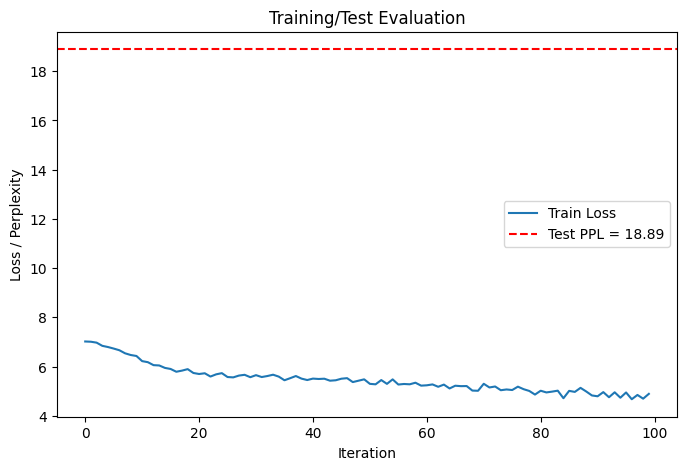

In [16]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_losses)), train_losses, label="Train Loss")
#plt.plot(steps, val_ppls, label="Validation PPL")
plt.axhline(test_ppl, color="red", linestyle="--", label=f"Test PPL = {test_ppl:.2f}")
plt.xlabel("Iteration")
plt.ylabel("Loss / Perplexity")
plt.legend()
plt.title("Training/Test Evaluation")
plt.show()


In [15]:
for line in test_texts[:3]:  # just first 3 test lines
    ctx = torch.tensor([tokenizer.encode(line)], dtype=torch.long, device=DEVICE)
    out = loaded.generate(ctx, max_new_tokens=30, temperature=0.9, top_k=50)
    print("Prompt", line)
    print("Generated:", tokenizer.decode(out[0].tolist()))
    print("-"*50)


Prompt: hi there  or any show that you'll show him: be not you ashamed to show, he'll not shame to tell you what it means. OPHELIA You are naught, you are naught: I'll mark the play. Prologue For us, and for our tragedy, Here stooping to your clemency, We beg your hearing patiently. Exit HAMLET Is this a prologue, or the posy of a ring? OPHELIA 'Tis brief, my lord. HAMLET As woman's love. Enter two Players, King and Queen Player King Full thirty times hath Phoebus' cart gone round Neptune's salt wash and Tellus' orbed ground, And thirty dozen moons with borrow'd sheen About the world have times twelve thirties been, Since love our hearts and Hymen did our hands Unite commutual in most sacred bands. Player Queen So many journeys may the sun and moon Make us again count o'er ere love be done! But, woe is me, you are so sick of late, So far from cheer and from your former state, That I distrust you. Yet, though I distrust, Discomfort you, my lord, it nothing must: For women's fear and lov